In [1]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt

import wecopttool as wot
from capytaine.io.meshio import load_from_meshio
import os

In [2]:
wot.set_loglevel('ERROR', capytaine=False)

results_dir = 'WaveBot_animations'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [3]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)

# create mesh object for WaveBot and add internal lid
mesh_obj = load_from_meshio(mesh, 'WaveBot')
lid_mesh = mesh_obj.generate_lid(-2e-2)

fb = cpy.FloatingBody(mesh=mesh_obj, lid_mesh=lid_mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

In [4]:
wavefreq = 0.2 # Hz
f1 = wavefreq
nfreq = 5

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
amplitude = 0.25 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

In [5]:
fname_string = 'bem_wavebot_f1_'+ str.replace(f'{f1}','.','p') +'Hz_nfreq'+ f'{nfreq}' +'.nc'
fname_wec = os.path.join(results_dir, fname_string)
if os.path.exists(fname_wec):
    bem_data = wot.read_netcdf(fname_wec)
else:
    bem_data = wot.run_bem(fb, freq)
    wot.write_netcdf(fname_wec, bem_data)

Output()

In [6]:
hd = wot.add_linear_friction(bem_data, friction = None) 
hd = wot.check_radiation_damping(hd)

In [7]:
## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

In [8]:
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None
nstate_opt = 2*nfreq

# controller = wot.pto.controller_pi
# nstate_opt = 2*neq

loss = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)
f_add = {'PTO': pto.force_on_wec}
constraints = []


In [9]:
wec = wot.WEC.from_bem(
    bem_data,
    constraints=constraints,
    friction=None,
    f_add=f_add,
)

In [10]:
obj_fun = pto.average_power
# obj_fun = pto.mechanical_average_power

options = {'maxiter': 200}
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )
opt_average_power = results[0].fun
print(f'Optimal average power: {opt_average_power} W')

C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.396965884825612
            Iterations: 11
            Function evaluations: 12
            Gradient evaluations: 11
Optimal average power: -239.6965884825612 W


In [11]:
nsubsteps = 5
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)

In [12]:
w_tdom = wec_tdom[0]
p_tdom = pto_tdom[0]

## Animation part

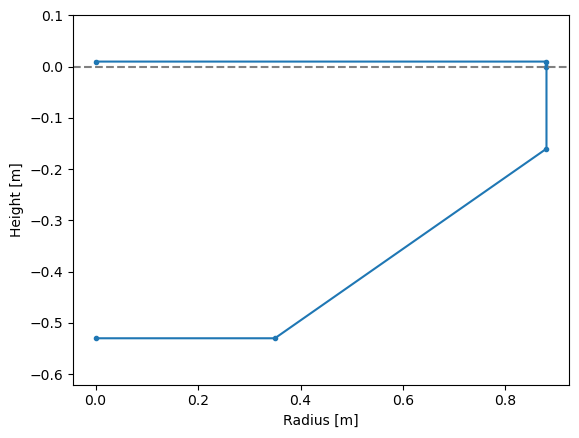

In [13]:
_ = wb.plot_cross_section(show=True) # specific to WaveBot

In [14]:
def WaveBot_hull_coords_heave(wb,z):
    y_r = np.array([-1*(wb.h1 - wb.freeboard + wb.h2),
        -1*(wb.h1 - wb.freeboard + wb.h2),
        -1*(wb.h1 - wb.freeboard),
        0,
        wb.freeboard,
        wb.freeboard]) + z
    x_r = np.array([0,
                wb.r2,
                wb.r1,
                wb.r1,
                wb.r1,
                0])
    y = np.concatenate([(np.flip(y_r)), np.transpose(y_r)])
    x = np.concatenate([(-np.flip(x_r)), x_r])
    return x,y


radiation
684.1670213645826
friction
0.0
hydrostatics
-6629.433629855765
Froude_Krylov
3571.114793367406
diffraction
-464.0783965087969
PTO
2463.295706714096


684.1670213645826

In [34]:
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"
plt.ioff()
fig, ax = plt.subplots()

# Set the limits of the plot
xlim = [-1.2, 1.2]
dx = xlim[1]-xlim[0]
ylim0 = -0.8
ylim = [ylim0, ylim0+dx]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

wave_number_deep = waves.omega**2/9.81

spatial_x = np.linspace(xlim[0], xlim[1], 10)
wave_elevations = np.zeros((len(spatial_x), len(w_tdom['time'])))
#phase shift waves
for i, x in enumerate(spatial_x):
    manual_wave = wot.waves.elevation_fd(f1, nfreq, 
                                        directions=waves.wave_direction, 
                                        nrealizations=len(waves.realization), 
                                        amplitudes=np.abs(waves), 
                                        phases=np.rad2deg(np.angle(waves) - np.expand_dims(wave_number_deep*x,axis=(1, 2))))    
    wave_td = wot.time_results(manual_wave, w_tdom['time'])
    wave_elevations[i, :] = wave_td[0, 0, :]

time = w_tdom['time']
frames = len(time)
wave_elev = w_tdom['wave_elev'].squeeze()
heave_pos = w_tdom['pos'].squeeze()
pow_norm_factor = 1500
pto_elec_power_norm = p_tdom['power'].sel(type = 'elec').squeeze()/pow_norm_factor
#TODO just loop over all forces and then plot them


def animate(frame):
    plt.cla()  # Clear the current axes
    ax.plot(spatial_x, wave_elevations[:, frame], color='b')
    # Get the predefined angles for the current frame


    # Calculate the x and y coordinates of the WaveBot 
    z = heave_pos[frame].item()
    x,y = WaveBot_hull_coords_heave(wb,z)
    plt.plot(x,y)

    power_pto = pto_elec_power_norm[frame].item()


    #power bar
    if power_pto < 0:
        plt.plot([1.1, 1.1],[0, 0-power_pto],  color='green', linewidth=10, alpha = 0.5)
    else:
        plt.plot([1.1, 1.1],[0, 0-power_pto],  color='red', linewidth=10, alpha = 0.5)
    plt.text(1.2, 0, f'{-1*power_pto*pow_norm_factor:.1f}W')
    
    cnt = 0
    for force_type in w_tdom['force'].type:
    # print(force_type.item())
        ax.plot([-0.04+0.02*cnt, -0.04+0.02*cnt] ,
              [0, w_tdom['force'].sel(type = force_type).squeeze()[frame].item()/10000],
              label = force_type.item())
        cnt = cnt +1

    # Set the limits and aspect ratio
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')  
    ax.grid(True)  
    ax.legend(loc = 'upper left')
    ax.set_title(f'Time = {time[frame]:.2f}')  
            
FuncAnimation(fig, animate, frames=frames, interval=int(1000*(time[1]-time[0])))